In [1]:
from pyteomics import mzxml, auxiliary
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from func import mz2n,rtsbaseB
from Chemometrics.basic import read_mzxml,get_rtrange
import pickle
import uuid
plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签
plt.rcParams['axes.unicode_minus']=False #用来正常显示负号
plt.rcParams['figure.figsize'] = (20, 6)
%matplotlib inline

In [2]:
df = read_mzxml("./data010.mzXML")

## 确定B组保留时间
- mz：mz=1331.8279+-0.0266Da
- rt：理论保留时间[10.081,10.987]+-0.1min
- intensity: 响应强度大于阈值，e.g. intensity>1000

In [3]:
intensity_threshold = 5000

In [4]:
d = df.loc[(df.mz-1331.8279).abs()<.0266]
plt.rcParams['figure.figsize'] = (20, 6)

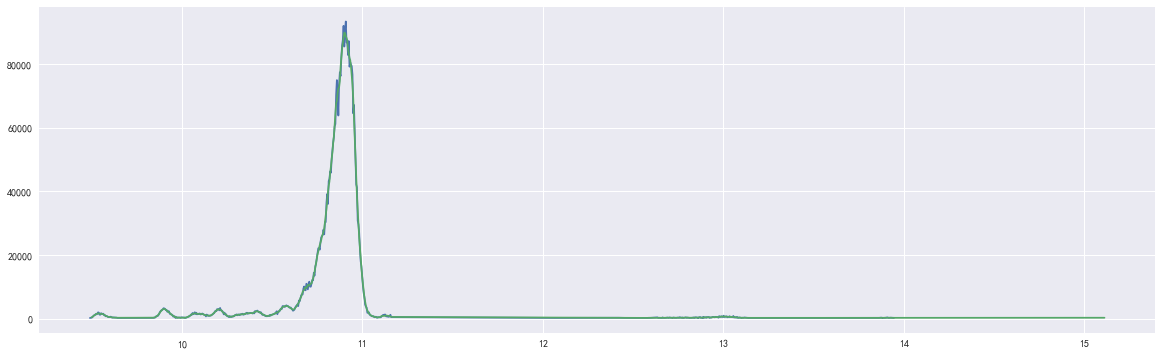

In [5]:
#EIC
plt.plot(d.rt[d.rt.between(9,14)],d.intensity[d.rt.between(9,14)])
plt.savefig('B组010-EIC',dpi = 300)
md = d.copy()
md['intensity'] = d.intensity.rolling(5,center=True).mean()
plt.plot(md.rt,md.intensity)

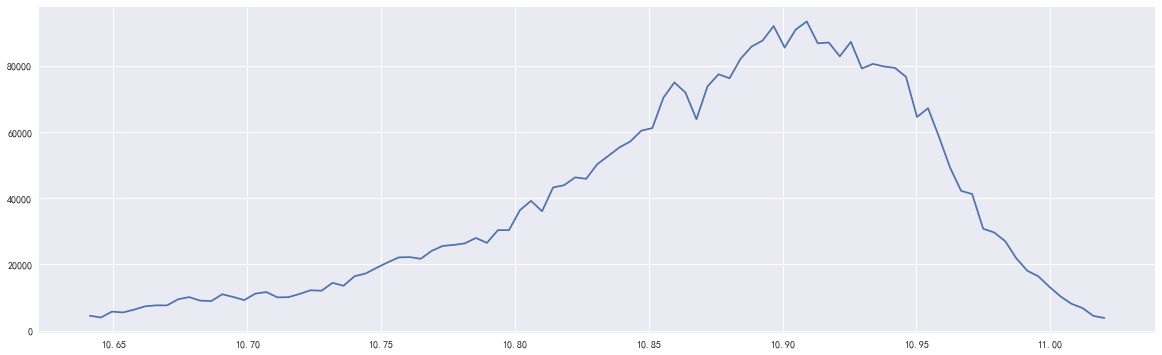

In [6]:
# B组实测保留时间范围
Brt = get_rtrange(d)[0:2:]
plt.plot(d.rt[d.rt.between(*Brt)],d.intensity[d.rt.between(*Brt)])

## 确定其他组保留时间

In [7]:
rt_all = rtsbaseB(Brt)
rt_all

,理论保留时间起点,实测保留时间起点,理论保留时间终点,实测保留时间终点
A-1,0.892,1.4522,0.949,0.9823
A-2,0.953,1.5132,1.056,1.0893
B,10.081,10.6412,10.987,11.0203
C,11.165,11.7252,11.985,12.0183
D,14.053,14.6132,15.046,15.0793
E,15.269,15.8292,16.200,16.2333
F,16.311,16.8712,17.309,17.3423
G,17.375,17.9352,18.026,18.0593


# 保留时间选取平均质谱图


In [17]:
dfB = df.loc[df.rt.between(*rt_all.loc['B',['实测保留时间起点','实测保留时间终点']])]

In [9]:
from Chemometrics.basic import avg_mass,rm_isotopes

In [14]:
avg = avg_mass(dfB)
dfB = dfB.sort_values('mz')

In [23]:
#(dfB.mz.diff()<1.1) & (dfB.mz.diff()>.9)
dfB.round(4).to_csv('B.txt',index=False)

In [12]:
(avg.mz.diff()<.51).head(10)

cat
9      False
276    False
278     True
310    False
311     True
312     True
339    False
340     True
344    False
345     True
Name: mz, dtype: bool

In [13]:
B = rm_isotopes(avg_mass(dfB))

# 过滤44

In [14]:
b = B.loc[~np.any(abs(abs(B.mz.values.reshape(-1,1)-B.mz.values)-22)<.1,axis=1)]
b = b.loc[np.any(abs(abs(b.mz.values.reshape(-1,1)-B.mz.values)-44)<.1,axis=1)]
B.head()

,mz,intensity
cat,,
9,158.191517,4628.510302
276,633.383824,3633.859672
310,655.397522,6748.717095
339,674.932748,2879.126886
344,677.410042,12332.243739


In [15]:
def filter_homo(mz_list, mass_num, base_on):
    #特征离子质量过滤 #过滤44
    mass_mask = np.any(abs((np.round(mz_list.values.reshape(-1, 1) - base_on )+ .01) % mass_num) < .1, axis=1)
    return mass_mask

In [16]:
def filter_h1(mz_list):
    mask0 = ~np.any(abs(abs(mz_list.values.reshape(-1,1)-mz_list.values)-22)<.1,axis=1)
    mask1 = np.any(abs(abs(mz_list.values.reshape(-1,1)-mz_list.values)-44)<.1,axis=1)
    mask = mask0 & mask1
    return mask

In [17]:
def rt2mz(rt_range):
    dfB = df.loc[df.rt.between(*rt_range)]
    avg = avg_mass(dfB)
    iso = rm_isotopes(avg)
    mz = iso.loc[filter_h1(iso.mz)].mz
    return mz

In [18]:
columns = ['实测保留时间起点','实测保留时间终点']
rtr = rt_all.loc[:,columns]

In [19]:
rtr

,实测保留时间起点,实测保留时间终点
A-1,1.4522,0.9823
A-2,1.5132,1.0893
B,10.6412,11.0203
C,11.7252,12.0183
D,14.6132,15.0793
E,15.8292,16.2333
F,16.8712,17.3423
G,17.9352,18.0593


In [20]:
rtr.loc['A-1',:]

实测保留时间起点    1.4522
实测保留时间终点    0.9823
Name: A-1, dtype: float64

# mz2n
根据质荷比找出PEG个数

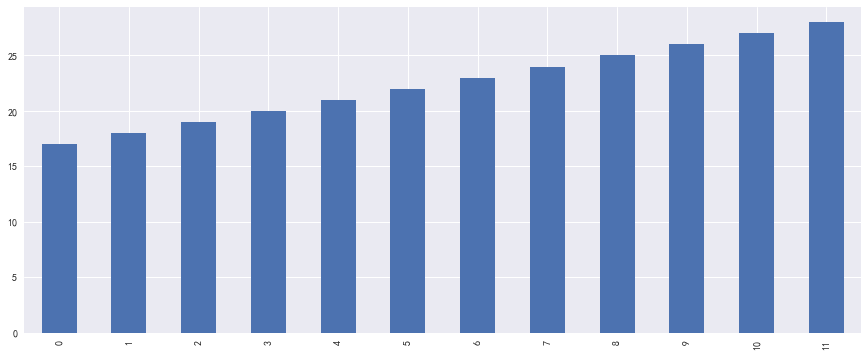

In [21]:
n = mz2n(b.mz,'B')
plt.rcParams['figure.figsize'] = (15, 6)
pd.Series(n[n>0].unique()).plot('bar')
plt.show()

# 画图

In [22]:
dfB = df.loc[df.rt.between(*rt_all.loc['B',['实测保留时间起点','实测保留时间终点']])]
vmax = np.percentile(dfB.intensity,90)

mass-B-54ff0555-fe57-4ac6-92b2-9fc91e00f3ab.png


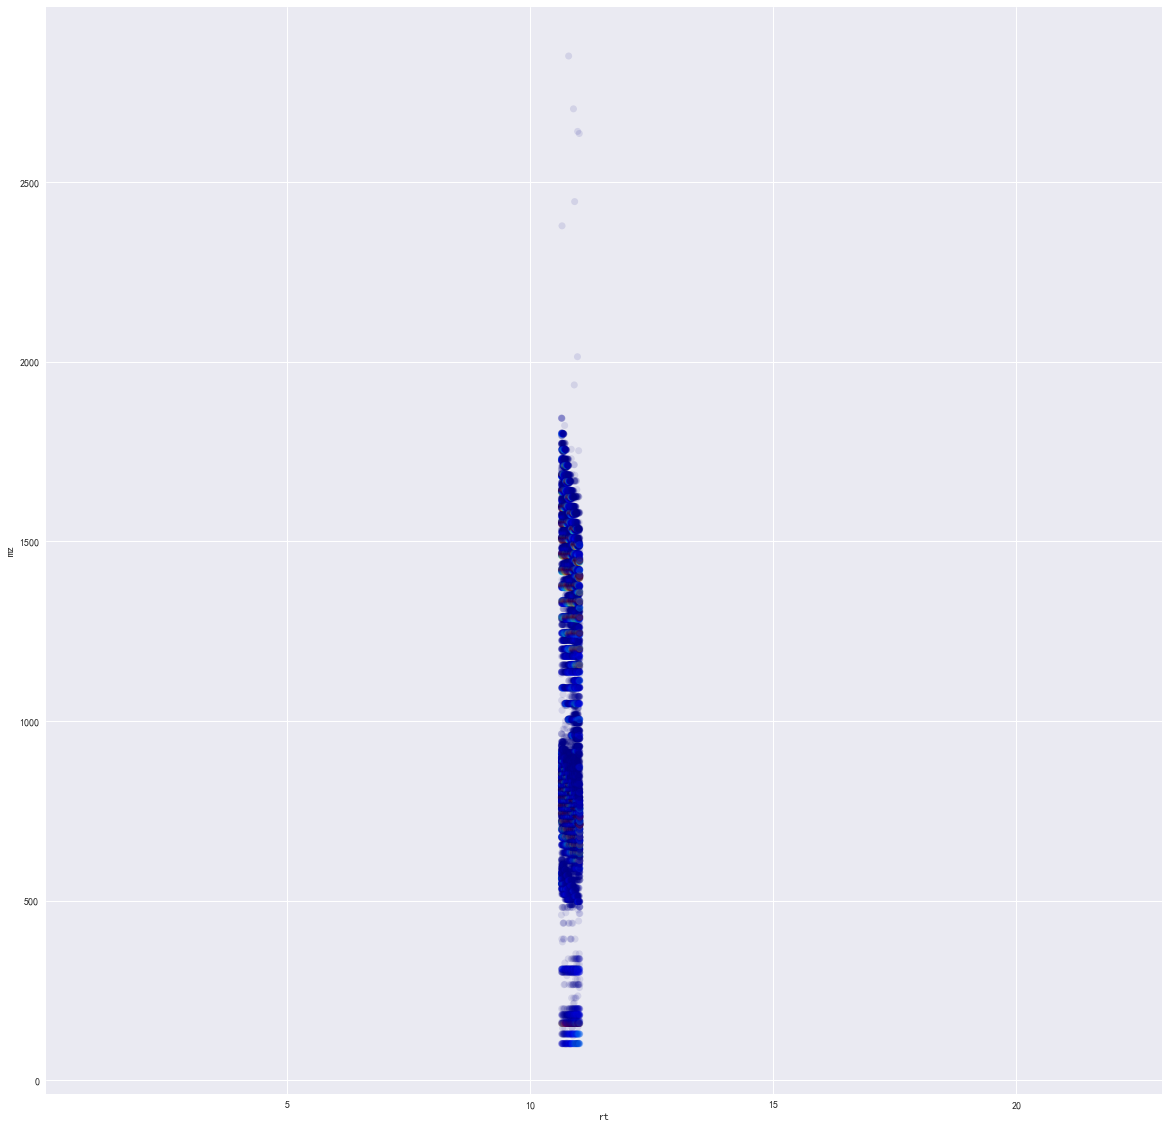

In [23]:
plt.rcParams['figure.figsize'] = (20, 20)
plt.scatter(dfB.rt,dfB.mz,c=dfB.intensity,vmax=vmax,alpha=0.1, cmap="jet", edgecolors="none")
plt.xlim(df.rt.min(),df.rt.max())
fig_name = 'mass-B-'+str(uuid.uuid4())+'.png'
plt.xlabel('rt')
plt.ylabel('mz')
print(fig_name)
#plt.savefig(fig_name,dpi = 300)

In [24]:
plt.show()